<a href="https://colab.research.google.com/github/danielfrgs/2022_1-Datos-Masivos-I/blob/main/Proyectos/P1/P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Proyecto

- Daniel Fragoso Alvarado
- Hugo Rangel Ramirez
- Jesus Enrique Gomez Martinez

datos: https://www.cs.cmu.edu/~ark/personas/

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 198 kB 44.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=8abe011b4e0ff64ba6e1d7f1ba7c0041dc3a9292dac2a8faf83be26ad27c6c3f
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [22]:
# Librerias
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

import cufflinks as cf
import pandas as pd
import pyspark
# Cargar Funciones Extra
from pyspark.sql.functions import * 
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Proyecto_1').getOrCreate()

<Figure size 640x480 with 0 Axes>

In [2]:
#Carga de bibliotecas extras
import numpy as np
import matplotlib.pyplot as plt

#Carga de NLTK
import nltk
nltk.download('stopwords')
import string

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielfragoso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Sobre los Datos:

La Base de Datos agrupa **42,306** resúmenes de tramas de películas extraídos de Wikipedia + metadatos alineados extraídos de Freebase, que incluyen:
- Ingresos de taquilla de películas, género, fecha de lanzamiento, tiempo de ejecución e idioma
- Nombres de personajes e información alineada sobre los actores que los interpretan, incluido el género y la edad estimada en el momento del estreno de la película.

En total el conunto de datos se conforma de 5 archivos, 2 de ellos en formato `.tsv` y el resto en `.txt`. Debido a la forma en que estaban conformdas, para darle un formarto util para nuestro análisis debemos de generar funciones axiliares que ayuden a su lectura:

Generación de Funciones auxiliares para limpiar algunos registros que se utilizaran posteriormente.

In [3]:
# Lectura de datos TSV
def read_tsv(direccion):
    import csv
    tsv_file = open(direccion)
    read_tsv = csv.reader(tsv_file, delimiter= "\t")
    lista = [row for row in read_tsv]
    tsv_file.close()
    return(spark.sparkContext.parallelize(lista))

# Lectura de datos TXT
def read_txt(direccion):
    import csv
    txt_file = open(direccion)
    read_tsv = csv.reader(txt_file, delimiter= "\t")
    lista = [row for row in read_tsv]
    txt_file.close()
    return(spark.sparkContext.parallelize(lista))

In [4]:
# Importamos datos:

character = read_tsv('MovieSummaries/character.metadata.tsv')
movie = read_tsv('MovieSummaries/movie.metadata.tsv')

In [7]:
name = read_txt('MovieSummaries/name.clusters.txt')
tvtropes = read_txt('MovieSummaries/tvtropes.clusters.txt')
plot_summaries =read_txt('MovieSummaries/plot_summaries.txt')

A pesar de haber generado la lectura debido a su formato original, no son compatibles con muchos de los recursos de Map, por lo que hay que generar una función auxiliar que nos permita limpiar los registros.

Ejemplo:

In [5]:
for x in movie.take(1):
    print(x)

22/03/01 19:09:01 WARN TaskSetManager: Stage 0 contains a task of very large size (4397 KiB). The maximum recommended task size is 1000 KiB.


['975900', '/m/03vyhn', 'Ghosts of Mars', '2001-08-24', '14010832', '98.0', '{"/m/02h40lc": "English Language"}', '{"/m/09c7w0": "United States of America"}', '{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}']


## ¿Cual es género más visto?

In [8]:
# Función que divide los géneros.

def sep_gen(renglon):
    renglon_separado = renglon[8]
    import re
    generos = re.findall(r'"([\w\s]+)"', renglon_separado)
    for g in generos:
        yield g

In [9]:
# Dado que queremos evitar la estructura anidada usaremos Flatmap()
genere = movie.flatMap(sep_gen)
genere = genere.map(lambda renglon: (renglon, 1))
# Conteo
genere_count = genere.reduceByKey(lambda val_1 , val_2: val_1 + val_2).sortBy(lambda renglon: renglon[1], ascending = False)

22/03/01 19:15:16 WARN TaskSetManager: Stage 1 contains a task of very large size (4397 KiB). The maximum recommended task size is 1000 KiB.


In [10]:
genere_count.take(10)

[('Drama', 34007),
 ('Comedy', 16349),
 ('Romance Film', 10234),
 ('Action', 8798),
 ('Thriller', 8744),
 ('Short Film', 8141),
 ('World cinema', 7155),
 ('Crime Fiction', 6948),
 ('Indie', 6897),
 ('Documentary', 5630)]

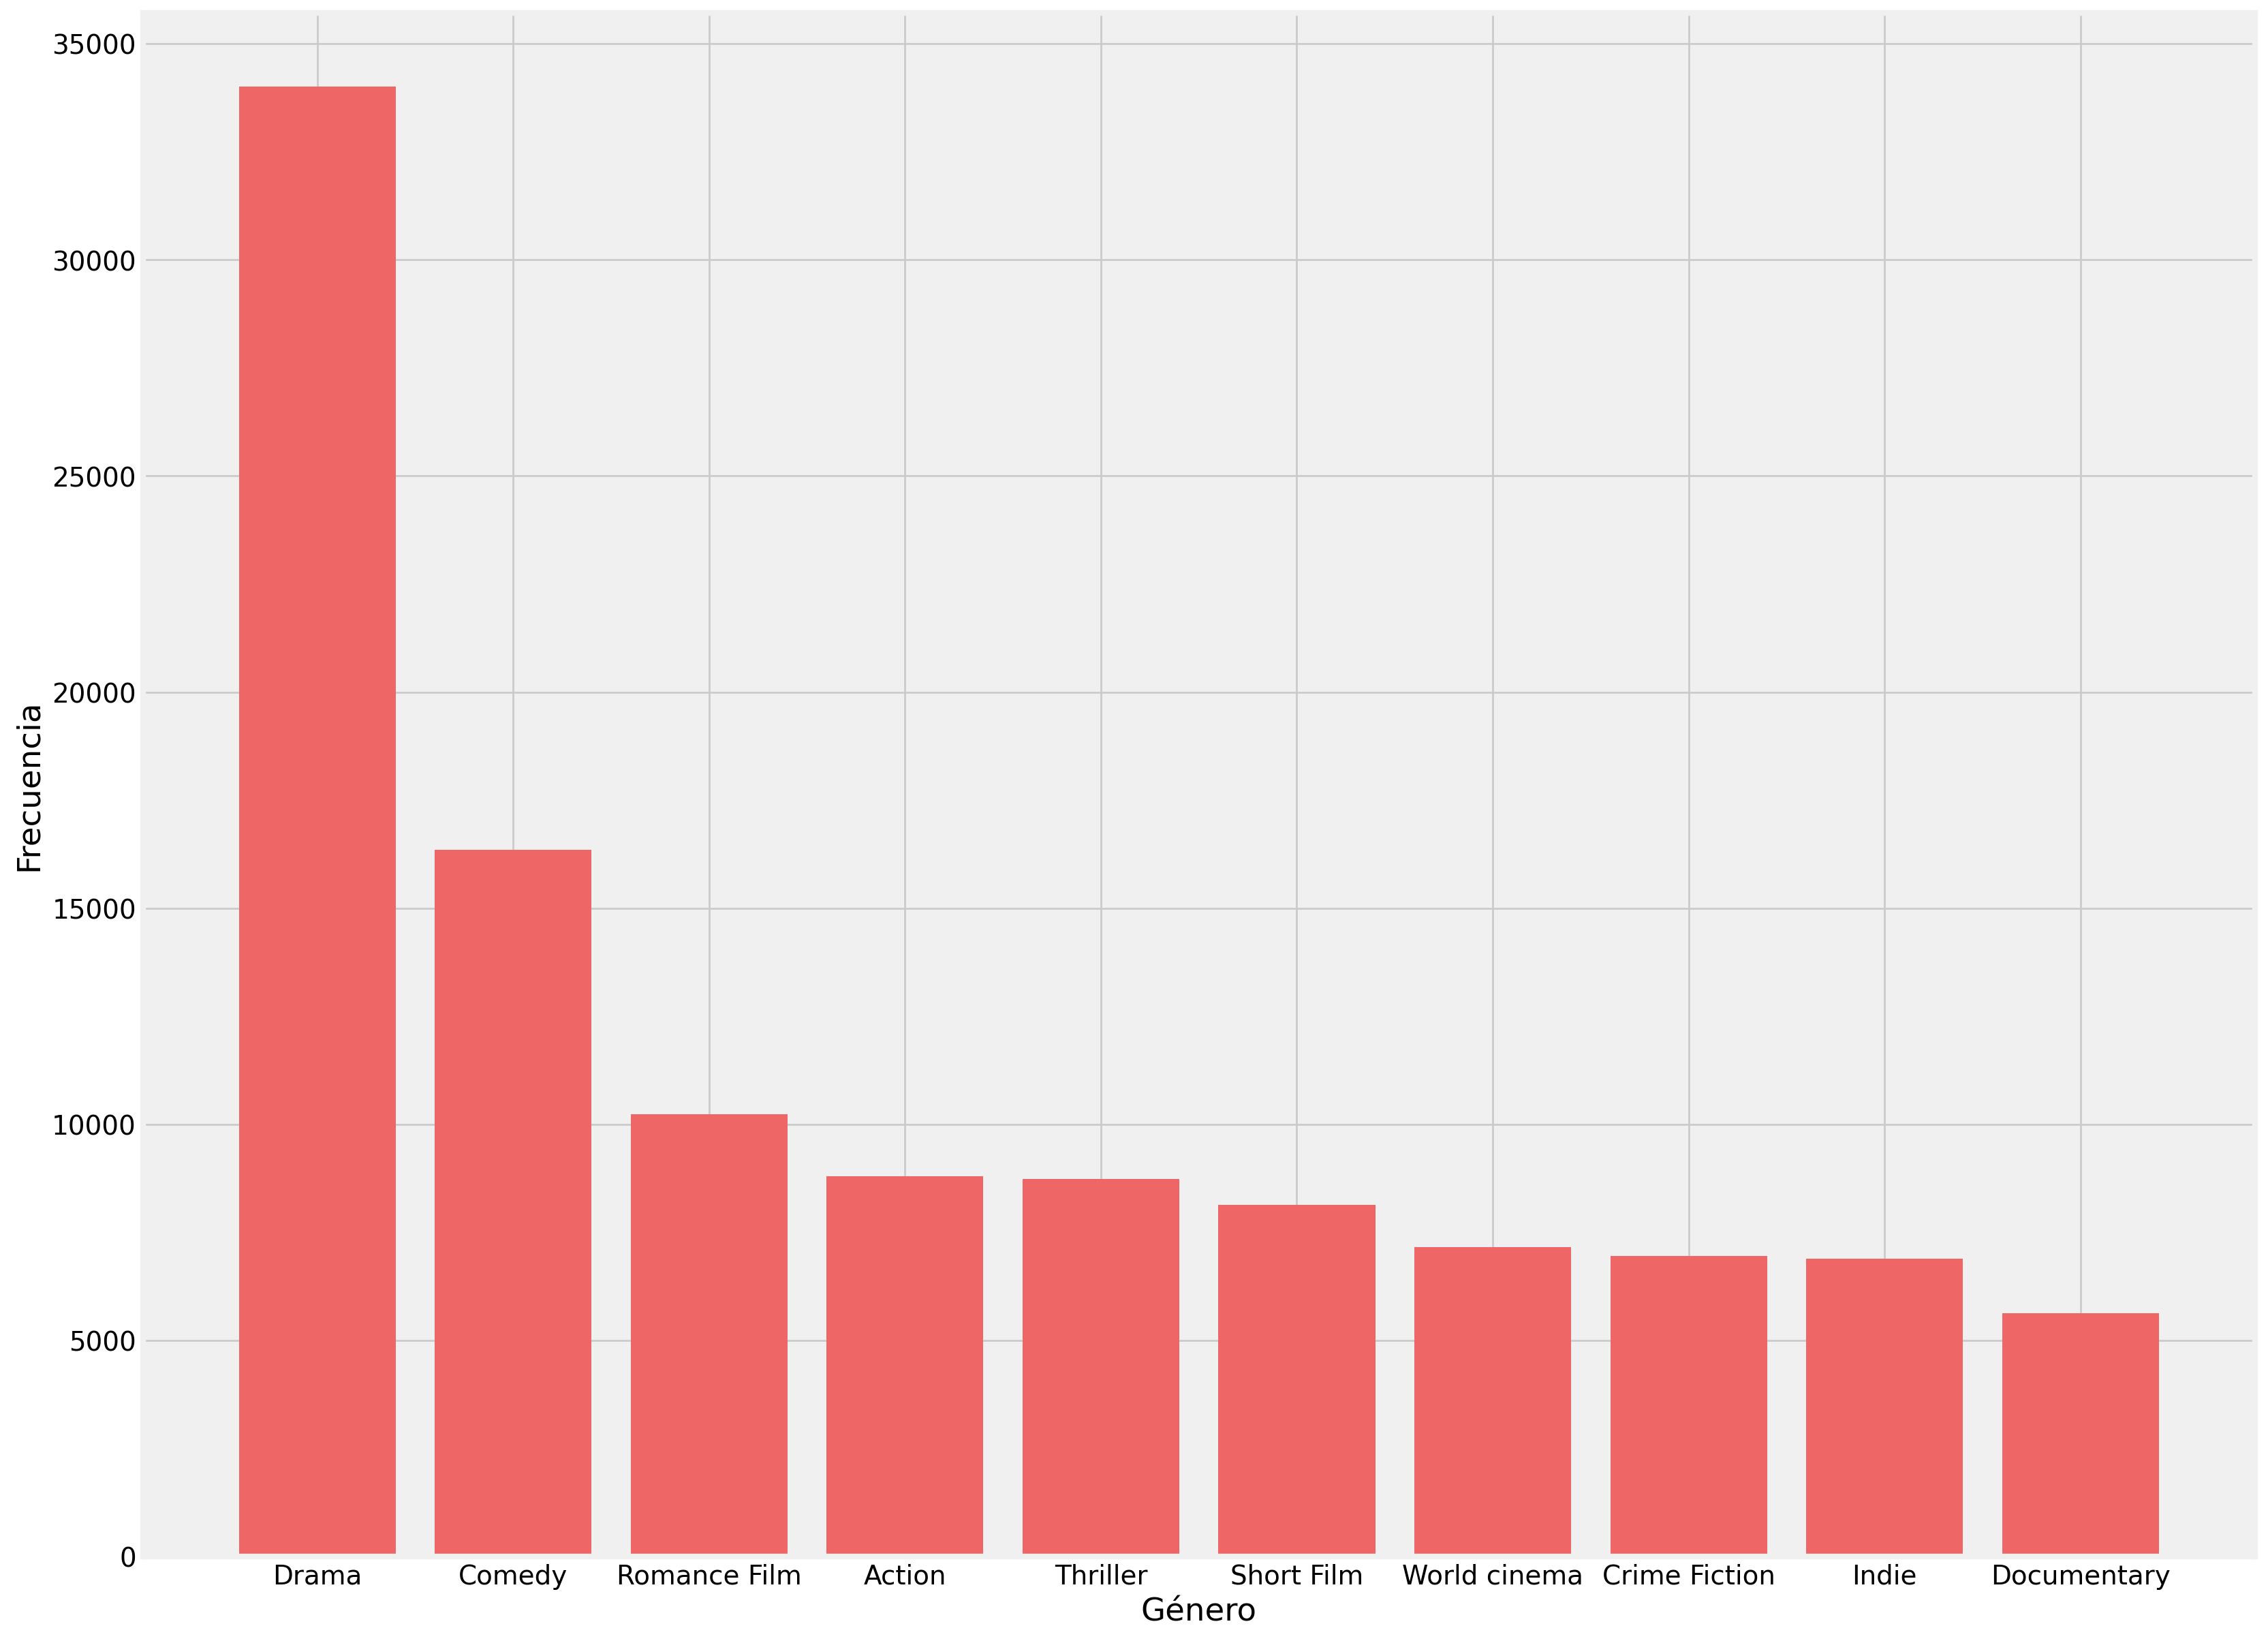

In [33]:
histograma = genere_count.take(10)#.collect()
numeros = [ numero for (numero, _) in histograma ]
frecuencias = [ frecuencia for (_, frecuencia) in histograma ]

figure(figsize=(20, 15), dpi=200)
with plt.style.context('fivethirtyeight'):
    plt.bar(numeros, frecuencias, color='#EE6666')

plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.show()
figsize =(10, 7)

## La palabra más larga de las descripciones




Generamos una función que compare la longitud de un string:

In [41]:
# Comparación de Strings
def com_string(x, y):
    if len(x) > len(y):
        return x
    return y

Al hacer un analsiis exploratorio nos percatamos que algunas sinopsis contaban con url's, por lo que procedimos a eliminar estos valores mediante una función:

In [42]:
#Eliminacion de url's
def del_url(renglon):
    import re
    generos = re.sub(r'http\S+', ' ', renglon)
    return generos

In [43]:
# Seleccionamos las sinopsis:
desc = plot_summaries.map(lambda x: x[1])
# Elminamos los url's
desc = desc.map(del_url)

In [45]:
# Reduzcamos a palabras

words = desc.map(lambda x: x.split(' '))

#Eliminamos signos de puntuación y espacios en blanco
import string
def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered

#Removemos stopwords
def removeStopWordsFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence

words = words.map(removeStopWordsFunct)
words = words.map(removePunctuationsFunct)


In [46]:
def sep(renglon):
    for g in renglon:
        return g

words_sep = words.map(sep)

In [47]:
# Comparamos los strings y lo reducimos:
word_legth = words_sep.reduce(com_string)

22/03/01 20:46:45 WARN TaskSetManager: Stage 70 contains a task of very large size (18273 KiB). The maximum recommended task size is 1000 KiB.


In [48]:
word_legth

'PlotdatePrologueThursdayMondaySaturdayTuesdayFridaySundayWednesdayEpilogue'

## Contar el número de veces que aparece la palabra 'war' en la descripción 

In [49]:
# Dividimos y limpiamos las sinopsis pero manteniendo el código de la pélicula 
cont = plot_summaries.map(lambda x: (x[0], x[1].split(' ')))
cont = cont.map(lambda x: (x[0], removeStopWordsFunct(x[1])))
cont = cont.map(lambda x: (x[0], removePunctuationsFunct(x[1])))

In [50]:
# Contamos la palabra guerra
cont_war = cont.map(lambda x: (x[0], x[1].count('war')))

In [51]:
# Ordenamos de forma desendente
cont_war = cont_war.sortBy(lambda renglon: renglon[1], ascending = False)

22/03/01 20:48:52 WARN TaskSetManager: Stage 71 contains a task of very large size (18273 KiB). The maximum recommended task size is 1000 KiB.
22/03/01 20:50:30 WARN TaskSetManager: Stage 72 contains a task of very large size (18273 KiB). The maximum recommended task size is 1000 KiB.


In [52]:
cont_war.take(5)

22/03/01 20:52:31 WARN TaskSetManager: Stage 73 contains a task of very large size (18273 KiB). The maximum recommended task size is 1000 KiB.


[('886892', 10),
 ('3843721', 9),
 ('3653120', 8),
 ('3903364', 8),
 ('1432805', 8)]

In [53]:
# Generamos un filtrado para mantener aquellas peliculas que al menos ,mencionan un avez la guerra
war_movies = cont_war.filter(lambda renglon: renglon[1] > 1)

## ¿Cual es la película que más menciona 'war' en su descripción?

In [54]:
movie.filter(lambda x: x[0] == '886892').take(1)

22/03/01 20:54:06 WARN TaskSetManager: Stage 75 contains a task of very large size (4397 KiB). The maximum recommended task size is 1000 KiB.


[['886892',
  '/m/03lv4x',
  'Breaker Morant',
  '1980',
  '4735000',
  '107.0',
  '{"/m/02h40lc": "English Language"}',
  '{"/m/0chghy": "Australia", "/m/0ctw_b": "New Zealand"}',
  '{"/m/01fc50": "Anti-war", "/m/0hj3mx2": "British Empire Film", "/m/03g3w": "History", "/m/04xvlr": "Period piece", "/m/07s9rl0": "Drama", "/m/082gq": "War film", "/m/07k67c": "Anti-war film", "/m/05bh16v": "Courtroom Drama"}']]

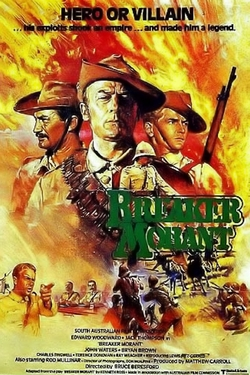

## ¿De que país provienen principalmente las películas de guerra?

In [55]:
war_movies.take(5)

[('886892', 10),
 ('3843721', 9),
 ('3653120', 8),
 ('3903364', 8),
 ('1432805', 8)]

In [56]:
country = movie.map(lambda x: (x[0], x[7]))
country.take(1)

22/03/01 20:54:16 WARN TaskSetManager: Stage 78 contains a task of very large size (4397 KiB). The maximum recommended task size is 1000 KiB.


[('975900', '{"/m/09c7w0": "United States of America"}')]

In [57]:
country_war = country.join(war_movies)

In [58]:
def sep_gen_2(renglon):
    renglon_separado = renglon[0]
    import re
    generos = re.findall(r'"([\w\s]+)"', renglon_separado)
    for g in generos:
        yield g

In [59]:
country_war = country_war.flatMap(lambda x: sep_gen_2(x[1]))

In [60]:
country_war_cont = country_war.map(lambda x: (x, 1)).reduceByKey(lambda val_1 , val_2: val_1 + val_2).sortBy(lambda renglon: renglon[1], ascending = False)

22/03/01 20:54:28 WARN TaskSetManager: Stage 80 contains a task of very large size (4397 KiB). The maximum recommended task size is 1000 KiB.


In [61]:
country_war_cont.take(10)

[('United States of America', 357),
 ('United Kingdom', 108),
 ('France', 61),
 ('Germany', 52),
 ('Japan', 49),
 ('Italy', 35),
 ('India', 34),
 ('Canada', 26),
 ('Australia', 17),
 ('Russia', 15)]

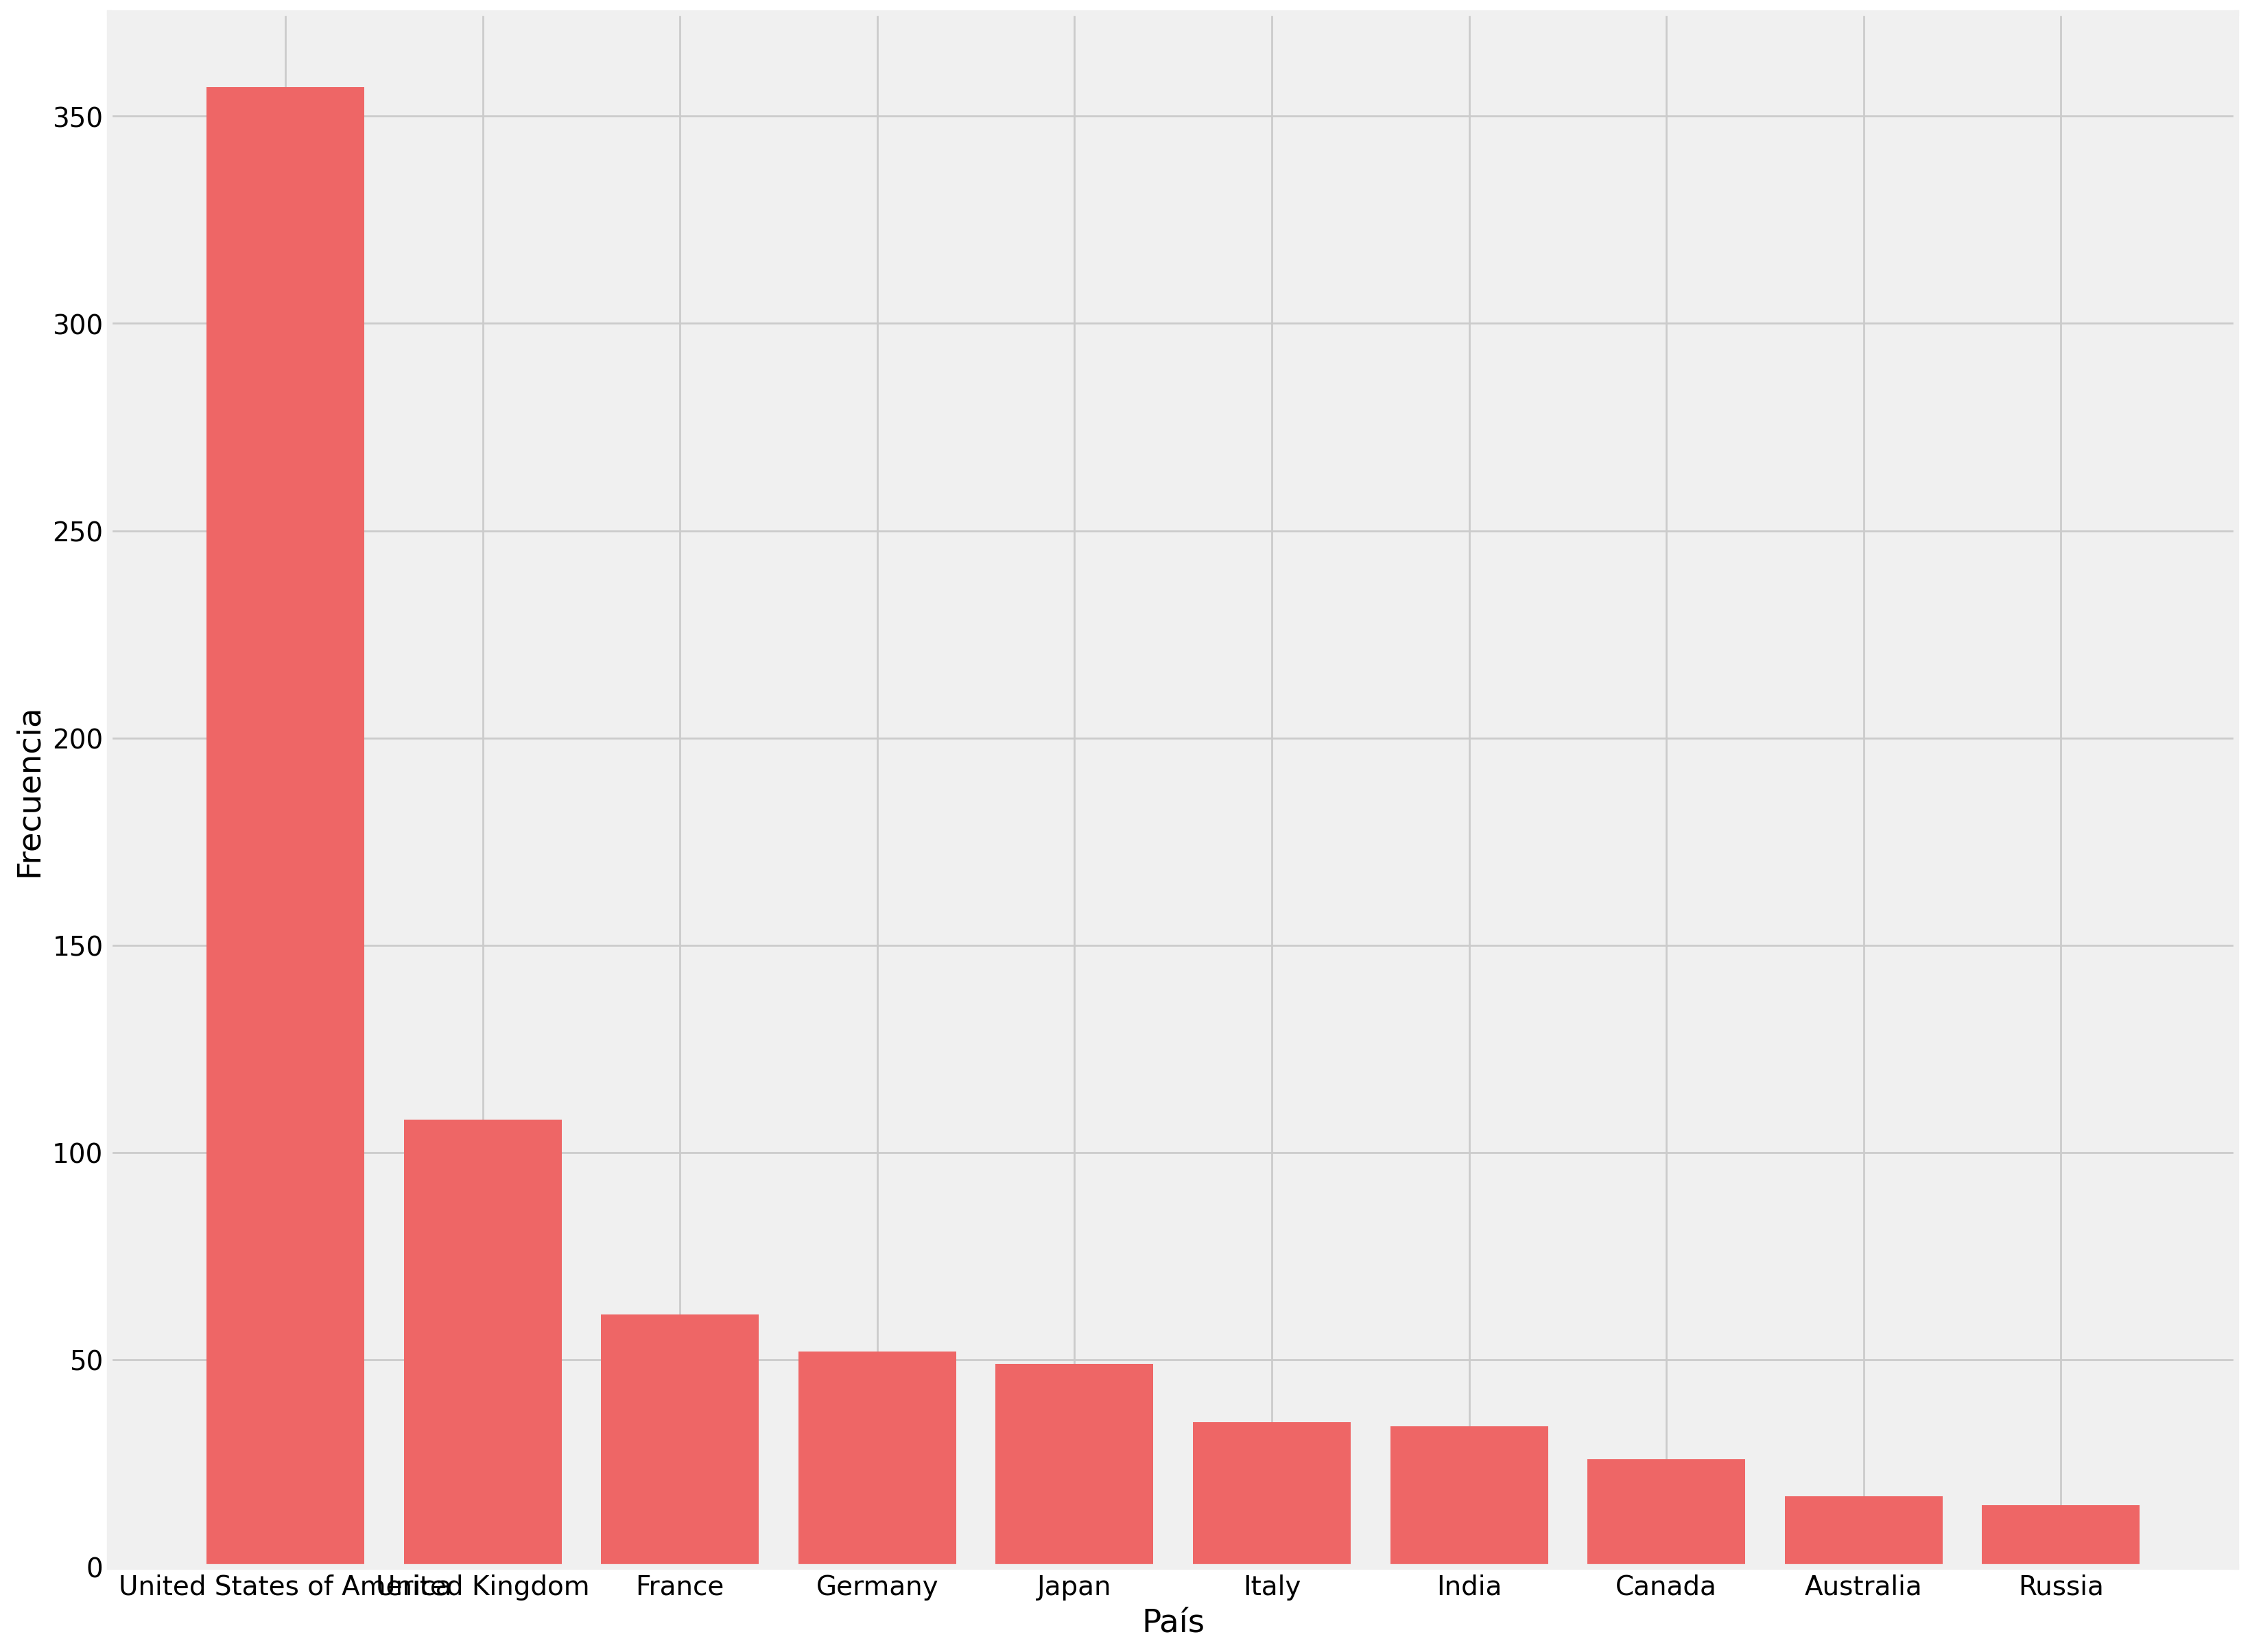

In [62]:
histograma = country_war_cont.take(10)#.collect()
numeros = [ numero for (numero, _) in histograma ]
frecuencias = [ frecuencia for (_, frecuencia) in histograma ]

figure(figsize=(20, 15), dpi=200)
with plt.style.context('fivethirtyeight'):
    plt.bar(numeros, frecuencias, color='#EE6666')

plt.xlabel('País')
plt.ylabel('Frecuencia')
plt.show()
figsize =(10, 7)

## ¿En qué año se estrenaron más películas y cuanto recaudó cada una?

In [138]:
year = movie.map(lambda x: (x[3], x[4]))

In [139]:
year.take(10)

22/03/01 23:11:57 WARN TaskSetManager: Stage 148 contains a task of very large size (4397 KiB). The maximum recommended task size is 1000 KiB.


[('2001-08-24', '14010832'),
 ('2000-02-16', ''),
 ('1988', ''),
 ('1987', ''),
 ('1983', ''),
 ('1913-05-29', ''),
 ('2002', ''),
 ('1938-08-16', '3600000'),
 ('1974', ''),
 ('1960', '')]

In [206]:
# Generammos la función para obtener los años y mmontos

def año(renglon):
    import re
    año = re.findall(r'.*([1-3][0-9]{3})', renglon[0])
    try:
        ren = int(float(renglon[1]))
    except:
        ren = 0
    for x in año:
        return(x, (ren, 1))
    
    

In [215]:
prueb = year.map(año).filter(lambda x: x is not None)
prueb.take(20)

22/03/02 00:04:58 WARN TaskSetManager: Stage 215 contains a task of very large size (4397 KiB). The maximum recommended task size is 1000 KiB.


[('2001', (14010832, 1)),
 ('2000', (0, 1)),
 ('1988', (0, 1)),
 ('1987', (0, 1)),
 ('1983', (0, 1)),
 ('1913', (0, 1)),
 ('2002', (0, 1)),
 ('1938', (3600000, 1)),
 ('1974', (0, 1)),
 ('1960', (0, 1)),
 ('1930', (0, 1)),
 ('1974', (0, 1)),
 ('1997', (0, 1)),
 ('1989', (10161099, 1)),
 ('1986', (0, 1)),
 ('1984', (0, 1)),
 ('1964', (102272727, 1)),
 ('1967', (0, 1)),
 ('1992', (0, 1)),
 ('1930', (0, 1))]

In [216]:
year_count = prueb.reduceByKey(lambda x, y: (x[0]+y[0],x[1]+y[1]))

In [217]:
year_count.take(10)

22/03/02 00:05:07 WARN TaskSetManager: Stage 216 contains a task of very large size (4397 KiB). The maximum recommended task size is 1000 KiB.


[('1983', (2604953274, 666)),
 ('2002', (17217637693, 1478)),
 ('1938', (23507371, 518)),
 ('1943', (16721675, 464)),
 ('1940', (200081221, 498)),
 ('1918', (0, 282)),
 ('1911', (0, 137)),
 ('1993', (7936976091, 915)),
 ('1939', (440400531, 487)),
 ('1991', (6018373216, 827))]

In [239]:
# Grñáfica
import plotly.graph_objects as px 
import numpy as np 
import plotly.io as pio
pio.templates

plot = px.Figure(data=[px.Scatter( 
    x = year_count.map(lambda x: int(x[0])).collect(), 
    y = year_count.map(lambda x: x[1][1]).collect(), 
    mode = 'markers', 
    #marker_size = year_count.map(lambda x: x[1][0]/1000000).collect()
    ) 
])

plot.show()

In [243]:
# Grñáfica

plot = px.Figure(data=[px.Scatter( 
    x = year_count.map(lambda x: int(x[0])).collect(), 
    y = year_count.map(lambda x: x[1][1]).collect(),
    mode = 'markers', 
    marker = dict( 
        color=year_count.map(lambda x: x[1][0]).collect(),
        size= year_count.map(lambda x: x[1][0]/600000000).collect(), 
        #sizemode='area', 
        #sizeref=2.*max(size)/(40.**2), 
        sizemin=4,
       # size_max=60,
        showscale=True
    )
    ) 
])

plot.show()

## ¿Qué palabras se repiten más?


In [29]:
# Visualización de RDD con datos
for letra in plot_summaries.take(5):
  print(letra)

['23890098', "Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."]
['31186339', 'The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual Hunger Games. The tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker\'s son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy. He warns them about the "Career" tributes who train intensively at special acad

In [30]:
# Transformar textos a minúsculas
plot_summaries_minus = plot_summaries.map(lambda x: (x[1].lower()))

for letra in plot_summaries_minus.take(5):
  print(letra)

shlykov, a hard-working taxi driver and lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.
the nation of panem consists of a wealthy capitol and twelve poorer districts. as punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual hunger games. the tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. in her first reaping, 12-year-old primrose everdeen is chosen from district 12. her older sister katniss volunteers to take her place. peeta mellark, a baker's son who once gave katniss bread when she was starving, is the other district 12 tribute. katniss and peeta are taken to the capitol, accompanied by their frequently drunk mentor, past victor haymitch abernathy. he warns them about the "career" tributes who train intensively at special academies and almost always win. du

In [31]:
# Separar texto por palabra
plot_summaries_sep = plot_summaries_minus.map(lambda x: (x.split(' ')))

for letra in plot_summaries_sep.take(5):
  print(letra)

['shlykov,', 'a', 'hard-working', 'taxi', 'driver', 'and', 'lyosha,', 'a', 'saxophonist,', 'develop', 'a', 'bizarre', 'love-hate', 'relationship,', 'and', 'despite', 'their', 'prejudices,', 'realize', 'they', "aren't", 'so', 'different', 'after', 'all.']
['the', 'nation', 'of', 'panem', 'consists', 'of', 'a', 'wealthy', 'capitol', 'and', 'twelve', 'poorer', 'districts.', 'as', 'punishment', 'for', 'a', 'past', 'rebellion,', 'each', 'district', 'must', 'provide', 'a', 'boy', 'and', 'girl', '', 'between', 'the', 'ages', 'of', '12', 'and', '18', 'selected', 'by', 'lottery', '', 'for', 'the', 'annual', 'hunger', 'games.', 'the', 'tributes', 'must', 'fight', 'to', 'the', 'death', 'in', 'an', 'arena;', 'the', 'sole', 'survivor', 'is', 'rewarded', 'with', 'fame', 'and', 'wealth.', 'in', 'her', 'first', 'reaping,', '12-year-old', 'primrose', 'everdeen', 'is', 'chosen', 'from', 'district', '12.', 'her', 'older', 'sister', 'katniss', 'volunteers', 'to', 'take', 'her', 'place.', 'peeta', 'mellark

In [32]:
# Quitar las stop words

def removeStopWordsFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence

plot_summaries_stop = plot_summaries_sep.map(removeStopWordsFunct)

for palabra in plot_summaries_stop.take(5):
  print(palabra)

['shlykov,', 'hard-working', 'taxi', 'driver', 'lyosha,', 'saxophonist,', 'develop', 'bizarre', 'love-hate', 'relationship,', 'despite', 'prejudices,', 'realize', 'different', 'all.']
['nation', 'panem', 'consists', 'wealthy', 'capitol', 'twelve', 'poorer', 'districts.', 'punishment', 'past', 'rebellion,', 'district', 'must', 'provide', 'boy', 'girl', '', 'ages', '12', '18', 'selected', 'lottery', '', 'annual', 'hunger', 'games.', 'tributes', 'must', 'fight', 'death', 'arena;', 'sole', 'survivor', 'rewarded', 'fame', 'wealth.', 'first', 'reaping,', '12-year-old', 'primrose', 'everdeen', 'chosen', 'district', '12.', 'older', 'sister', 'katniss', 'volunteers', 'take', 'place.', 'peeta', 'mellark,', "baker's", 'son', 'gave', 'katniss', 'bread', 'starving,', 'district', '12', 'tribute.', 'katniss', 'peeta', 'taken', 'capitol,', 'accompanied', 'frequently', 'drunk', 'mentor,', 'past', 'victor', 'haymitch', 'abernathy.', 'warns', '"career"', 'tributes', 'train', 'intensively', 'special', 'ac

In [33]:
# Quitar los signos de puntuación 

import string
def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered

plot_summaries_punct = plot_summaries_stop.map(removePunctuationsFunct)

for palabra in plot_summaries_punct.take(5):
  print(palabra)

['shlykov', 'hardworking', 'taxi', 'driver', 'lyosha', 'saxophonist', 'develop', 'bizarre', 'lovehate', 'relationship', 'despite', 'prejudices', 'realize', 'different', 'all']
['nation', 'panem', 'consists', 'wealthy', 'capitol', 'twelve', 'poorer', 'districts', 'punishment', 'past', 'rebellion', 'district', 'must', 'provide', 'boy', 'girl', '', 'ages', '12', '18', 'selected', 'lottery', '', 'annual', 'hunger', 'games', 'tributes', 'must', 'fight', 'death', 'arena', 'sole', 'survivor', 'rewarded', 'fame', 'wealth', 'first', 'reaping', '12yearold', 'primrose', 'everdeen', 'chosen', 'district', '12', 'older', 'sister', 'katniss', 'volunteers', 'take', 'place', 'peeta', 'mellark', 'bakers', 'son', 'gave', 'katniss', 'bread', 'starving', 'district', '12', 'tribute', 'katniss', 'peeta', 'taken', 'capitol', 'accompanied', 'frequently', 'drunk', 'mentor', 'past', 'victor', 'haymitch', 'abernathy', 'warns', 'career', 'tributes', 'train', 'intensively', 'special', 'academies', 'almost', 'always

In [34]:
# Aplanar las palabras

def unir(lista):
  todos = []
  for i in range(len(lista)):
    for j in range(len(lista[i])):
      todos.append(lista[i][j])
  return lista

plot_summaries_flat = plot_summaries_punct.flatMap(unir)

for palabra in plot_summaries_flat.take(10):
  print(palabra)

shlykov
hardworking
taxi
driver
lyosha
saxophonist
develop
bizarre
lovehate
relationship


In [35]:
# Contar ocurrencias de las palabras

plot_summaries_palabras = plot_summaries_flat.map(lambda x: (x,1)) \
                                              .reduceByKey(lambda a,b: a+b) \
                                              .sortBy(lambda x: x[1], ascending = False)

for palabra in plot_summaries_palabras.take(10):
  print(palabra)

('', 142895)
('one', 31215)
('him', 27672)
('back', 24460)
('two', 21753)
('film', 20271)
('tells', 19109)
('her', 18468)
('father', 18338)
('man', 18170)


## Q-Gramas

In [36]:
# Función para sacar q-gramas
def gramas(palabra, q):
  n = len(palabra)
  lista_gramas = []
  for i in range(n-q+1):
    lista_gramas.append((palabra[i:i+q],1))
  return lista_gramas

In [37]:
# Contar ocurrencias de bigramas
plot_summaries_bigramas = plot_summaries_flat.flatMap(lambda x: gramas(x,2)) \
                                              .reduceByKey(lambda a, b: a + b) \
                                              .sortBy(lambda x: x[1], ascending = False)

for palabra in plot_summaries_bigramas.take(10):
  print(palabra)

('in', 888731)
('er', 778264)
('es', 680630)
('re', 585268)
('an', 562525)
('ng', 556631)
('ar', 514032)
('en', 512426)
('on', 505966)
('te', 484857)


In [38]:
# Cuenta de bigramas
plot_summaries_bigramas.count()

3433

In [39]:
# Ver qué bigramas se repiten menos

p = plot_summaries_bigramas.sortBy(lambda x: x[1], ascending = True)

for palabra in p.take(10):
  print(palabra)

('—q', 1)
('íq', 1)
('äv', 1)
('6¢', 1)
('’”', 1)
('c′', 1)
('o‘', 1)
('而不', 1)
('不改', 1)
('改是', 1)


In [40]:
# Función para detectar gramas validos
import re

def valido_grama(grama, n):

  pattern = re.compile("[a-z]{" + str(n) + "}")
  if pattern.match(grama):
    return True

valido_grama('ac', 2)

True

In [41]:
# Bigramas validos menos repetidos
p = plot_summaries_bigramas.filter(lambda x : valido_grama(x[0],2)).sortBy(lambda x: x[1], ascending = True)

for palabra in p.take(10):
  print(palabra)

('bx', 1)
('fq', 2)
('jq', 2)
('wx', 2)
('vq', 2)
('qd', 3)
('qy', 3)
('qx', 3)
('cx', 3)
('qz', 4)


In [42]:
# Cuenta bigramas, esperados: 26^2=276
p.count()

673

In [43]:
# Contar ocurrencias por trigrama
plot_summaries_trigramas = plot_summaries_flat.flatMap(lambda x: gramas(x,3)). \
                                              reduceByKey(lambda a, b: a + b). \
                                              sortBy(lambda x: x[1], ascending = False)

for palabra in plot_summaries_trigramas.take(10):
  print(palabra)

('ing', 435139)
('ent', 160454)
('ter', 150150)
('her', 140996)
('ion', 134398)
('the', 125719)
('ers', 123246)
('ate', 114046)
('all', 112322)
('ver', 105528)


In [44]:
# Trigramas validos menos repetidos
p = plot_summaries_trigramas.filter(lambda x : valido_grama(x[0],3)).sortBy(lambda x: x[1], ascending = True)

for palabra in p.take(10):
  print(palabra)

('uop', 1)
('nyq', 1)
('yqv', 1)
('ehj', 1)
('uvt', 1)
('vty', 1)
('drw', 1)
('doq', 1)
('xmp', 1)
('yje', 1)


## Porcentaje de Peliculas que mencionan una Palabra


In [45]:
def pertenece(palabra, documento):
  if palabra in documento:
    return 1
  else: 
    return 0

In [46]:
def cuenta(palabra):
  plot_summaries_cuenta = plot_summaries_punct.map(lambda x: pertenece(palabra, x)).reduce(lambda a,b:a+b)

  print(plot_summaries_cuenta)

cuenta('father')

9084


In [47]:
cuenta('gay')

578


In [48]:
def porcentaje(palabra):
  plot_summaries_cuenta = plot_summaries_punct.map(lambda x: pertenece(palabra, x)).reduce(lambda a,b:a+b)

  print(str(plot_summaries_cuenta*100/plot_summaries_punct.count()))

porcentaje('father')

21.473654350755265


In [49]:
porcentaje('gay')

1.3663333569723188


# Terminos despectivos

In [50]:
cont_f = cont.map(lambda x: (x[0], x[1].count('faggot')))
cont_f = cont_f.sortBy(lambda renglon: renglon[1], ascending = False)
cont_f.take(5)

[('23753991', 3),
 ('5752544', 2),
 ('17997162', 1),
 ('12298570', 1),
 ('1834238', 1)]

In [51]:
character.filter(lambda x: x[0] == '23753991').take(1)

[['23753991',
  '/m/06zshz4',
  '2009',
  '',
  '',
  '',
  '',
  '',
  'Cameron Mitchell Mason',
  '',
  '/m/0gcjgpp',
  '',
  '/m/0gbz7bj']]

# ¿Equidad?

In [52]:
waiter=cuenta('waiter')
waitress=cuenta('waitress')
mister=cuenta('mister')
miss=cuenta('miss')
actor=cuenta('actor')
actress=cuenta('actress')
businessman=cuenta('businessman')
businesswoman=cuenta('businesswoman')
girl=cuenta('girl')
boy=cuenta('boy')
policeman=cuenta('policeman')
policewoman=cuenta('policewoman')

196
352
36
741
768
773
865
54
5773
3499
556
27


In [53]:
cuenta('man')
cuenta('woman')

10482
6636


In [54]:
cuenta('father')
cuenta('mother')

9084
7085


In [55]:
cuenta('dad')
cuenta('mom')

685
423


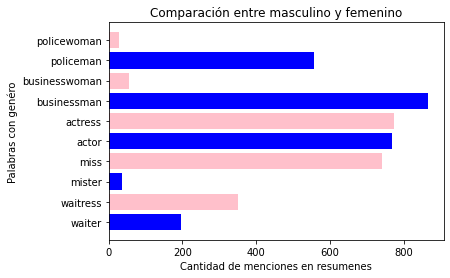

In [56]:
import matplotlib.pyplot as plt

eje_x = ['waiter', 'waitress', 'mister', 'miss', 'actor', 'actress', 'businessman', 'businesswoman', 'policeman', 'policewoman']
eje_y = [196,352,36,741,768,773,865,54,556,27]
 
plt.barh(eje_x, eje_y, color=['blue', 'pink'])
 
plt.xlabel('Cantidad de menciones en resumenes')
 
plt.ylabel('Palabras con genéro')
 
plt.title('Comparación entre masculino y femenino')
 
plt.show()

In [57]:
cuenta('jesus')
cuenta('hugo')
cuenta('enrique')
cuenta('blanca')
cuenta('daniel')
cuenta('john')

203
82
32
17
290
2061


In [58]:
cuenta('barbie')

36
